<a href="https://colab.research.google.com/github/brokoli777/Emotion-Recogntion/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# Import libraries for data manipulation, visualization and warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

# Import tensorflow and keras for deep learning tools
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import (
    Input,
    Dense,
    Conv2D,
    Dropout,
    Flatten,
    MaxPooling2D,
    BatchNormalization,
    Activation,
    LeakyReLU,
    GlobalAveragePooling2D,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

NUM_CLASSES = 7
TARGET_SIZE = (48, 48)  # Target image size for resizing
INPUT_SHAPE = (48, 48, 1)  # grayscale image

In [ ]:
# Import kagglehub to download datasets from Kaggle
import kagglehub

# Download FER2013 dataset from Kaggle (didplay path for referrence)
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:03<00:00, 16.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


# Collab

In [ ]:
# Import shutil library for file operations 
import shutil

# Define source and destination paths for dataset
source = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
destination = "/content/dataset"

# Move dataset files from source to destination folder (display where moved to for referrence)
shutil.move(source, destination)
print(f"Files moved to {destination}")

In [64]:
# Define the paths for training and testing directories
# TRAIN_DIR = './dataset/train' for collab
# TEST_DIR = './dataset/test' for collab

TRAIN_DIR = 'ds/train' # for local
TEST_DIR = 'ds/test' # for local

In [65]:
# Display the contents of the dataset directories
print(os.listdir(TRAIN_DIR))
print(os.listdir(TEST_DIR))
print(len(os.listdir(TRAIN_DIR+'/angry')))
print(len(os.listdir(TRAIN_DIR+'/disgust')))

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
3995
436


In [66]:
# Function to load the dataset images and their labels
def load_dataset(directory):
    image_paths = []  # List for storing image paths
    labels = []       # List for storing labels

    # Iterate through each label in the dataset directory
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)  # Use os.path.join to create label path
        if not os.path.isdir(label_path):  # Skip if it's not a directory
            continue

        # Iterate through the images within the label directory
        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)  # Append image path
                labels.append(label)            # Append label

        # Display completion validation
        print(label, "Completed")

    return image_paths, labels

In [67]:
# Convert training dataset into a DataFrame
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)

# Mix up the training dataset
# set seed for reproducibility
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train.head()


test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)
test.head()

happy Completed
sad Completed
fear Completed
surprise Completed
neutral Completed
angry Completed
disgust Completed
happy Completed
sad Completed
fear Completed
surprise Completed
neutral Completed
angry Completed
disgust Completed


,image,label
0,ds/test/fear/PublicTest_61467201.jpg,fear
1,ds/test/sad/PublicTest_56624502.jpg,sad
2,ds/test/neutral/PublicTest_46749562.jpg,neutral
3,ds/test/neutral/PrivateTest_2440389.jpg,neutral
4,ds/test/happy/PublicTest_15146220.jpg,happy


In [68]:
for label in os.listdir(TRAIN_DIR):
    label_path = os.path.join(TRAIN_DIR, label)
    if os.path.isdir(label_path):
        print(f"{label}: {len(os.listdir(label_path))} images")

happy: 7215 images
sad: 4830 images
fear: 4097 images
surprise: 3171 images
neutral: 4965 images
angry: 3995 images
disgust: 436 images


In [ ]:
def get_features(image_paths, target_size=(48, 48), color_mode='grayscale'):
    img_features = []
    for image_path in image_paths:
        if not os.path.exists(image_path):
            import sys
            print(f"Image not found: {image_path}", file=sys.stderr)
            continue
        try:
            img = load_img(image_path, target_size=target_size, color_mode=color_mode)
            img = img_to_array(img) / 255.0  # Normalize
            img_features.append(img)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    return np.array(img_features).reshape(-1, *target_size, 1)


In [70]:
def validate_features(features, target_shape=(48, 48, 1)):

    if features.shape[1:] != target_shape:
        print(f"Validation failed: Expected shape {target_shape}, but got {features.shape[1:]}.")
        return False

    if np.any(np.isnan(features)) or np.any(np.isinf(features)):
        print("Validation failed: Found NaN or infinite values in features.")
        return False

    if np.min(features) < 0.0 or np.max(features) > 1.0:
        print("Validation failed: Feature values are not in the range [0, 1].")
        return False
    
    print("Validation passed: All checks passed.")
    return True

In [71]:
# Extract the features from training and testing datasets
TARGET_SIZE = (48, 48)
train_features = get_features(train['image'],  target_size=TARGET_SIZE)
test_features = get_features(test['image'], target_size=TARGET_SIZE)

# validation of features train & test

if validate_features(train_features) and validate_features(test_features):
    print("Features validation passed.")
else:
    print("Features validation failed.")


Validation passed: All checks passed.
Validation passed: All checks passed.
Features validation passed.


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to training labels
label_encoder.fit(train["label"])

# Transform both training and testing labels to integer values
# 0 to 6 for the 7 classes start from angry to neutral
y_train = label_encoder.transform(train["label"])
y_test = label_encoder.transform(test["label"])

# Convert integer labels to one-hot encoded vectors using Keras
# Dynamic exact number of classes
num_classes = len(label_encoder.classes_)

"""
To convert the integer labels to one-hot encoded vectors, we can use the to_categorical function from Keras.
This function takes the integer labels and the number of classes as input and returns the one-hot encoded vectors.
"""

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

# Output the one-hot encoded vectors and classes
print("One-hot encoded labels (first 5 rows):")
print(y_train[:5])
print("Classes:")
print(label_encoder.classes_)

One-hot encoded labels (first 5 rows):
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
Classes:
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [89]:
x_train = train_features
x_test = test_features
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (28709, 48, 48, 1)
x_test shape: (7178, 48, 48, 1)
y_train shape: (28709, 7)
y_test shape: (7178, 7)


In [90]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

In [120]:
# Build the CNN model
model = Sequential()
model.add(Input(shape=INPUT_SHAPE))

# First convolutional block
# - The 32 filters help the model learn 32 distinct patterns or features from the input data.
# - The kernel size (3x3) determines the receptive field used to scan the input.
# - ReLU (Rectified Linear Unit) activation introduces non-linearity to enable the model
#   to learn complex relationships between features.
# This layer extracts low-level features such as edges and textures from the input image.
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# Add a batch normalization layer immediately after the convolutional layer.
# - This layer normalizes the outputs of the convolutional layer to have a mean of 0
#   and a standard deviation of 1, which helps stabilize the learning process.
# - It reduces sensitivity to weight initialization and allows the model to train faster.
# Batch normalization also acts as a regularizer, reducing the chances of overfitting.
model.add(BatchNormalization())

# Second convolutional block
# - Increase filters to 64
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

# - Add a max pooling layer with a pool size of 2x2.
# - This layer downsamples the spatial dimensions of the feature maps,
# - reducing computation and helping the model focus on dominant features.
model.add(MaxPooling2D(pool_size=(2, 2)))

# - Add a dropout layer with a dropout rate of 0.5.
# - This randomly sets 50% of the neurons to zero during training to prevent overfitting
# - and improve the generalization capability of the model.
model.add(Dropout(0.5))

# Third convolutional block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fourth convolutional block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fully connected layers
model.add(Flatten())  # Flatten feature maps

# - The large number of neurons (1024) provides the model with significant capacity
# - to learn intricate details in the data.
model.add(Dense(1024, activation='relu')) # Fully connected layer
model.add(Dropout(0.2)) # Dropout

# - Each neuron corresponds to one of the 7 emotion classes in the dataset.
# - The softmax activation function ensures that the output values represent probabilities
# - and sum to 1, making it suitable for multi-class classification tasks.
model.add(Dense(7, activation='softmax')) # Output layer

# Display the model summary
model.summary()

# Complie the model using Adam optimizer and categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 19, 19, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 17, 17, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 17, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 884,679 (3.37 MB)

 Trainable params: 884,103 (3.37 MB)

 Non-trainable params: 576 (2.25 KB)

In [117]:
model2 = Sequential()
model2.add(Input(shape=INPUT_SHAPE))

# Convolutional Input Layer
model2.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

# Convolutional HL 2
model2.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

# Convolutional HL 3
model2.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

# Global Average Pooling
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.3))

# Output Layer
model2.add(Dense(7, activation="softmax"))

# Compile the model
opti = Adam(learning_rate=0.0005)
model2.compile(optimizer=opti, loss="categorical_crossentropy", metrics=["accuracy"])
model2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,279 (399.53 KB)

 Trainable params: 101,831 (397.78 KB)

 Non-trainable params: 448 (1.75 KB)

- Validation Loss Fluctuations:
- Validation loss fluctuates significantly (e.g., jumping from 1.8796 to 4.0646 and then back to 1.8438), indicating potential overfitting or instability in training.

- Drop in Performance in Later Epochs:
	•	After an initial improvement, performance metrics degrade in some epochs (e.g., validation loss increases to 3.9991 in epoch 5), possibly due to overfitting, inadequate regularization, or a mismatch in data preprocessing between training and validation datasets.

In [123]:
# Setup for early stopping and learning rate reduction callbacks
# - Callback stops training early if validation loss does not improve
# - within given number of epochs (50)
early_stopping = EarlyStopping("val_loss", patience=50)

# Define the ReduceLROnPlateau callback.
# - This reduces the learning rate when the validation loss stops improving.
# - `monitor='val_loss'`: Monitors the validation loss during training.
# - `factor=0.1`: Reduces the learning rate by a factor of 10 when triggered.
# - `patience=int(50/4)`: Waits for approximately 12 epochs (1/4 of `patience` for early stopping) without improvement before reducing the learning rate.
# - `verbose=1`: Logs messages to the console when the learning rate is reduced.
reduce_lr = ReduceLROnPlateau("val_loss", factor=0.1, patience=int(50 / 4), verbose=1)

# Train the model
# - `x=x_train, y=y_train`: The training data and corresponding labels.
# - `batch_size=64`: Specifies the number of training samples processed before the model updates.
# - `epochs=40`: The maximum number of times the entire training dataset is processed.
# - `verbose=1`: Displays detailed progress information during training.
# - `validation_data=(x_test, y_test)`: Specifies the validation dataset for monitoring validation performance.
# - `callbacks=[early_stopping, reduce_lr]`: Adds the early stopping and learning rate reduction callbacks
# - to dynamically manage training termination and learning rate adjustments.

if len(train_features) != len(y_train):
    print("Length of train_features and y_train are not equal")
else:
    model_info = model.fit(
        x=x_train,
        y=y_train,
        epochs=40, # 40 epochs finer tuning
        batch_size=128,
        verbose=1, # display progress
        validation_data=(x_test, y_test),
        callbacks=[early_stopping, reduce_lr],
    )

Epoch 1/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.3920 - loss: 1.5473 - val_accuracy: 0.3912 - val_loss: 1.6600 - learning_rate: 0.0010
Epoch 2/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4404 - loss: 1.4408 - val_accuracy: 0.3863 - val_loss: 1.6918 - learning_rate: 0.0010
Epoch 3/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4703 - loss: 1.3630 - val_accuracy: 0.5000 - val_loss: 1.2912 - learning_rate: 0.0010
Epoch 4/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4947 - loss: 1.3063 - val_accuracy: 0.5085 - val_loss: 1.2679 - learning_rate: 0.0010
Epoch 5/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5201 - loss: 1.2585 - val_accuracy: 0.4929 - val_loss: 1.3386 - learning_rate: 0.0010
Epoch 6/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5357 - loss: 1.2266 - val_accuracy: 0.5411 - val_loss: 1.1945 - learning_rate: 0.0010
Epoch 7/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5460 - loss: 1

In [124]:
model_info2 = model2.fit(
    x=x_train,
    y=y_train,
    epochs=40,
    verbose=1,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2688 - loss: 1.7750 - val_accuracy: 0.2073 - val_loss: 1.8874 - learning_rate: 5.0000e-04
Epoch 2/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3036 - loss: 1.7252 - val_accuracy: 0.3018 - val_loss: 1.7278 - learning_rate: 5.0000e-04
Epoch 3/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3325 - loss: 1.6764 - val_accuracy: 0.3149 - val_loss: 1.7114 - learning_rate: 5.0000e-04
Epoch 4/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3613 - loss: 1.6248 - val_accuracy: 0.3729 - val_loss: 1.6041 - learning_rate: 5.0000e-04
Epoch 5/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3859 - loss: 1.5659 - val_accuracy: 0.4043 - val_loss: 1.5192 - learning_rate: 5.0000e-04
Epoch 6/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4064 - loss: 1.5257 - val_accuracy: 0.4610 - val_loss: 1.4484 - learning_rate: 5.0000e-04
Epoch 7/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - acc

In [ ]:
# Evaluate the accuracy
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Model 1: Test loss: {loss:.4f}, accuracy: {accuracy:.4f}")

loss2, accuracy2 = model2.evaluate(x_test, y_test, verbose=0)
print(f"Model 2: Test loss: {loss2:.4f}, accuracy: {accuracy2:.4f}")


Model 1: Test loss: 1.0946, accuracy: 0.6258
Model 2: Test loss: 1.1190, accuracy: 0.5770
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [ ]:
# Save the model structure and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Save the trained model weight in .h5 file
model.save_weights('model.weights.h5')

In [ ]:
# Save the complete model in .keras format
model.save("finalmodel.keras")

In [133]:
# Plot the training accuracy and loss graphs
accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

accuracy2 = model_info2.history['accuracy']  # Training accuracy for Model 2
val_accuracy2 = model_info2.history['val_accuracy']  # Validation accuracy for Model 2
loss2 = model_info2.history['loss']  # Training loss for Model 2
val_loss2 = model_info2.history['val_loss']  # Validation loss for Model 2

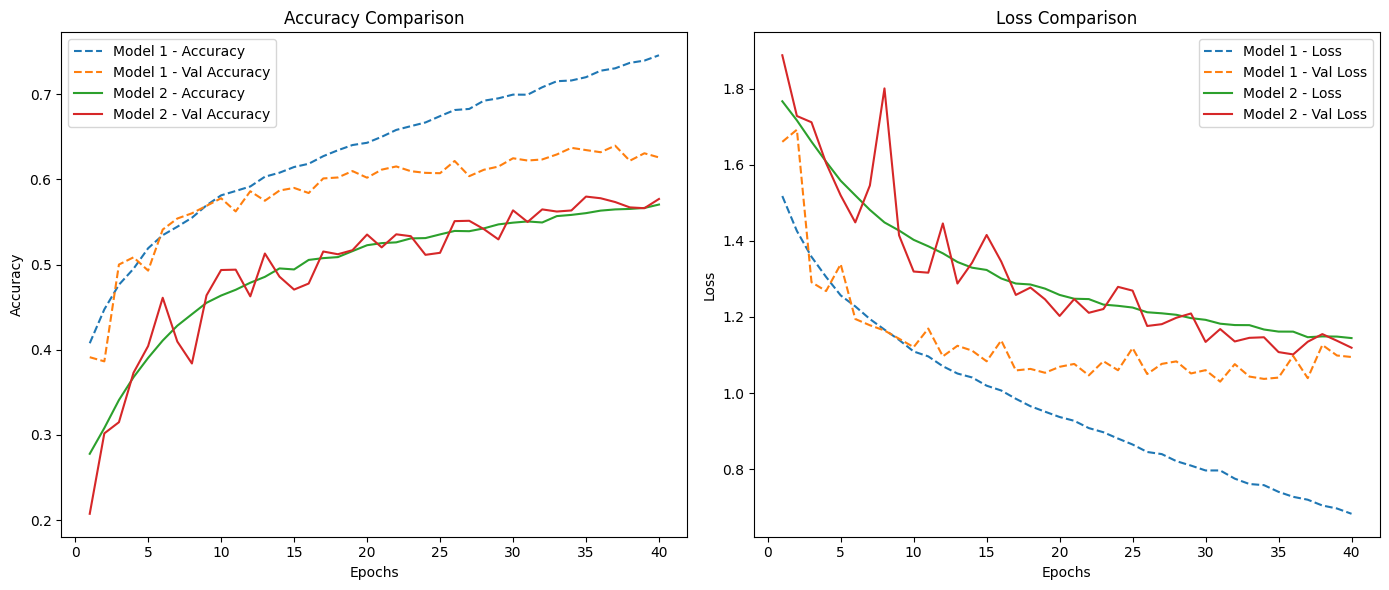

In [134]:

# Plot accuracy comparison
plt.figure(figsize=(14, 6))
epochs = range(1, len(accuracy) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Model 1 - Accuracy', linestyle='--')
plt.plot(epochs, val_accuracy, label='Model 1 - Val Accuracy', linestyle='--')
plt.plot(epochs, accuracy2, label='Model 2 - Accuracy', linestyle='-')
plt.plot(epochs, val_accuracy2, label='Model 2 - Val Accuracy', linestyle='-')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Model 1 - Loss', linestyle='--')
plt.plot(epochs, val_loss, label='Model 1 - Val Loss', linestyle='--')
plt.plot(epochs, loss2, label='Model 2 - Loss', linestyle='-')
plt.plot(epochs, val_loss2, label='Model 2 - Val Loss', linestyle='-')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

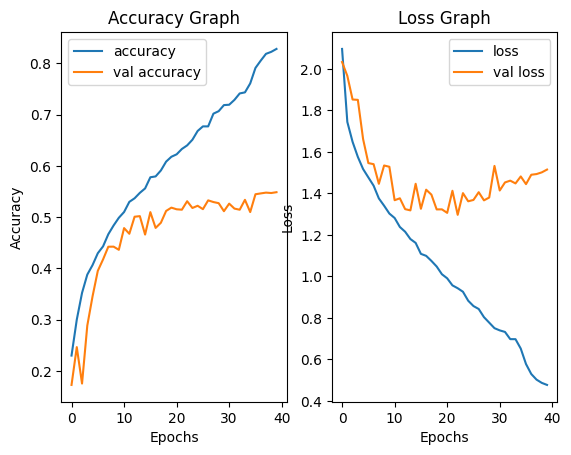

In [ ]:
# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Output: happy


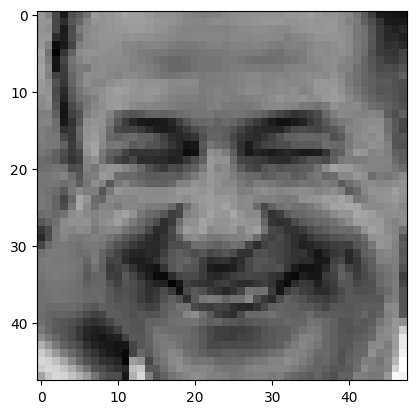

In [ ]:
# Test the model on a random image from the test set
image_index = random.randint(0, len(test))  # Pick image using random index number
print("Original Output:", test['label'][image_index]) # Display original label

# Predict the label using trained model
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1)) # Reshape to mathc model dimensions

# Decode predicted label back to original string with LabelEncoder
prediction_label = encode.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label) # Display predicted label

# Display test image in grayscale to see input
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');